In [23]:
#importing necessary libraries
import pandas as pd
import glob
import os
import warnings
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
# importing custom scripts for different functions
sys.path.append('scripts')  # add scripts to path




# Ignore warnings
warnings.filterwarnings("ignore")

In [24]:
#loading the combined df
combined_df = pd.read_csv("../notebook/combined.csv")

## Exploratory Data Analysis

In [25]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [26]:
#checking for missing/null values
combined_df.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [44]:
#checking for duplicates
combined_df.duplicated().sum()

4259

In [45]:
#dropping duplicates
combined_df.drop_duplicates(inplace=True)

In [46]:
#grouping data by market and filling missing values in the 'County' column with the mode of the respective market
combined_df['County'] = combined_df.groupby('Market')['County'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [ ]:
#impute missing values in the supply volume column with the median value of the respective market
combined_df['Supply Volume'] = combined_df.groupby("Commodity")["Supply Volume"].transform(lambda x: x.fillna(x.median()))

In [42]:
combined_df.describe()

,Supply Volume
count,3.923500e+04
mean,1.041572e+04
std,6.400056e+05
min,0.000000e+00
25%,4.200000e+02
50%,1.200000e+03
75%,3.200000e+03
max,1.000000e+08


In [27]:
#converting dates into date format using pd.to_datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,NaN,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [28]:
#keeping columns that will be used in the model
data=combined_df.drop(columns=['Classification', 'Grade', 'Sex', 'Market'], axis=1)

In [29]:
#removing 'Kg' and other symbols from the retail and wholesale columns
for col in ['Retail', 'Wholesale']:
    data[col] = (
        data[col]
        .astype(str)
        .str.replace('/Kg', '', regex=False)
        .str.replace('-', '', regex=False)
        .str.strip()
    )

In [30]:
#converting the retail and wholesale columns to numeric columns
for col in ['Retail', 'Wholesale']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Commodity      57010 non-null  object        
 1   Wholesale      45298 non-null  float64       
 2   Retail         54612 non-null  float64       
 3   Supply Volume  39235 non-null  float64       
 4   County         56991 non-null  object        
 5   Date           57010 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 2.6+ MB


In [31]:
# Aggregate
df_monthly = (
    data
    .groupby(['County', 'Commodity', pd.Grouper(key='Date', freq='MS')])
    .agg({'Retail': 'mean',
          'Wholesale': 'mean'})
    .reset_index()
)
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6355 entries, 0 to 6354
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   County     6355 non-null   object        
 1   Commodity  6355 non-null   object        
 2   Date       6355 non-null   datetime64[ns]
 3   Retail     6302 non-null   float64       
 4   Wholesale  5731 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 248.4+ KB


In [32]:
def enforce_monthly_index(group):
    idx = pd.date_range(
        start=group['Date'].min(),
        end=group['Date'].max(),
        freq='MS'
    )
    group = (
        group
        .set_index('Date')
        .reindex(idx)
    )
    group['County'] = group['County'].iloc[0]
    group['Commodity'] = group['Commodity'].iloc[0]
    return group.reset_index().rename(columns={'index': 'Date'})

In [33]:
df_complete = (
    df_monthly
    .groupby(['County', 'Commodity'], group_keys=False)
    .apply(enforce_monthly_index)
)
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9189 entries, 0 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9189 non-null   datetime64[ns]
 1   County     9189 non-null   object        
 2   Commodity  9189 non-null   object        
 3   Retail     6302 non-null   float64       
 4   Wholesale  5731 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 430.7+ KB


In [34]:
df_complete=df_complete.set_index('Date')
df_complete = df_complete.sort_index()
df_complete[['Retail', 'Wholesale']] = (
    df_complete
    .groupby(['County', 'Commodity'])[['Retail', 'Wholesale']]
    .apply(lambda x: x.interpolate(method='time'))
)

In [35]:
df_complete

,County,Commodity,Retail,Wholesale
Date,,,,
2022-02-01,Nyandarua,Wheat,56.000000,48.0000
2022-02-01,Kisii,Wheat,80.000000,60.0000
2022-02-01,Uasin-Gishu,Wheat,80.000000,50.0000
2022-02-01,Trans-Nzoia,Wheat,75.000000,58.8900
2022-02-01,Kirinyaga,Wheat,66.666667,57.5000
...,...,...,...,...
2026-02-01,Trans-Nzoia,Beans (Yellow-Green),61.332500,49.0825
2026-02-01,Meru,Wheat,90.000000,75.0000
2026-02-01,Kirinyaga,Meat Beef,158.300000,137.0000


In [36]:
#checking for null values in the new df
df_complete.isnull().sum()

County         0
Commodity      0
Retail        17
Wholesale    220
dtype: int64

In [37]:
# filling missing values in each group
def clean_price(series):
	clean_series = pd.to_numeric(series.astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
	return clean_series

data["Wholesale"] = clean_price(data["Wholesale"])
data["Retail"] = clean_price(data["Retail"])

In [38]:
df_complete["Commodity"].value_counts()

Red Irish potato               957
Wheat                          890
Meat Beef                      651
Banana (Ripening)              648
Omena                          623
Finger Millet                  574
Cowpea leaves (Kunde)          566
Spinach                        502
Banana (Cooking)               472
Beans Red Haricot (Wairimu)    443
Beans (Yellow-Green)           443
Cowpeas                        442
Kales/Sukuma Wiki              419
Dry Maize                      378
Dry Onions                     378
Cabbages                       371
Rice                           293
Maize Flour                    134
Red Sorghum                      5
Name: Commodity, dtype: int64

### *Commodities with the highest sales*

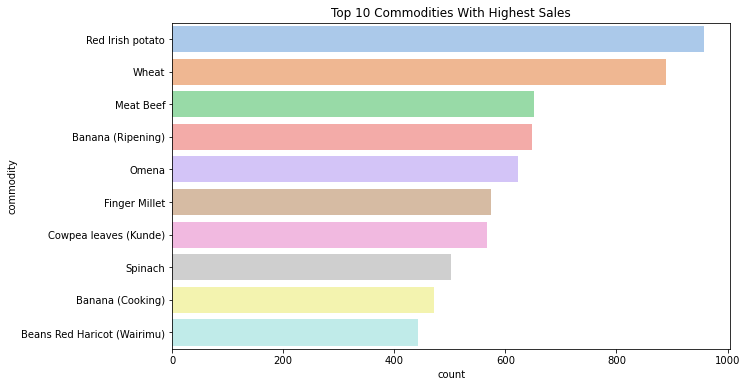

In [39]:
top_10_commodities = (
    df_complete["Commodity"].value_counts().head(10).reset_index()
)
top_10_commodities.columns = ["commodity", 'count']

plt.figure(figsize=(10,6))
sns.barplot(data=top_10_commodities, x ="count", y="commodity",  palette="pastel")
plt.title("Top 10 Commodities With Highest Sales")
plt.show()

Retail and Wholesale Commodity Price Trends

<AxesSubplot:title={'center':'Commodity Retail Price Trend'}, xlabel='Date'>

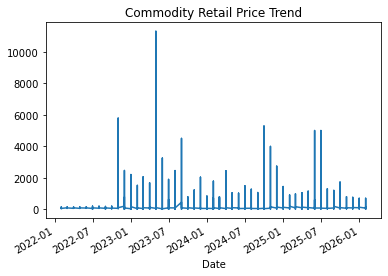

In [40]:
df_complete['Retail'].plot(title='Commodity Retail Price Trend')

Peak in prices occur slightly around January, probably due to dry weather conditions and July,supply around this time is a bit tight as most harvests occur around August-October

<AxesSubplot:title={'center':'Commodity Wholesale Price Trend'}, xlabel='Date'>

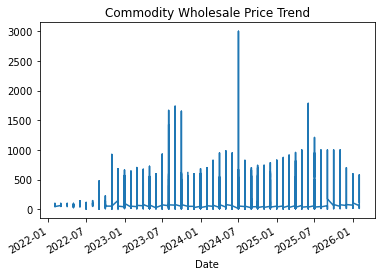

In [41]:
df_complete['Wholesale'].plot(title='Commodity Wholesale Price Trend')

### *Feature Engineering*